This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from world_models_sonic.models.vae import VAE6, loss_function_vae
from world_models_sonic.helpers.summarize import TorchSummarizeDf
from world_models_sonic.helpers.dataset import load_cache_data
from world_models_sonic.models.rnn import MDNRNN2
from world_models_sonic.models.inverse_model import InverseModel
from world_models_sonic.models.world_model import WorldModel
from world_models_sonic.custom_envs.wrappers import discrete_actions
from world_models_sonic import config
len(discrete_actions)

10

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 1

# VAE loss function
lambda_vae_kld = 0.25
C = 0
z_dim = 256 # latent dimensions

# RNN
action_dim = 10
seq_len = 8
image_size=256
chunksize=seq_len*20



# loss function weights
lambda_vae = 1/20
lambda_finv = 1

data_cache_file = os.path.join(config.base_vae_data_dir, 'sonic_rnn_256_v30.hdf5')
NAME='RNN_v3b_256im_512z_v6_greenfield'

In [5]:
if not os.path.isdir('./outputs/{NAME}'.format(NAME=NAME)):
    os.makedirs('./outputs/{NAME}'.format(NAME=NAME))
    
data_cache_file = os.path.join(config.data_cache_dir, 'sonic_rnn_256_v31.hdf5')
history_file = './outputs/{NAME}/history.csv'.format(NAME=NAME)
save_file_rnn = './outputs/{NAME}/mdnrnn_state_dict.pkl'.format(NAME=NAME)
save_file_vae = './outputs/{NAME}/vae_state_dict.pkl'.format(NAME=NAME)
save_file_finv = './outputs/{NAME}/finv_state_dict.pkl'.format(NAME=NAME)

# Load Data

In [6]:
loader_train, loader_test = load_cache_data(
    basedir=config.base_vae_data_dir, 
    env_name=env_name, 
    data_cache_file=data_cache_file, 
    image_size=image_size, 
    chunksize=chunksize, 
    action_dim=action_dim,
    batch_size=batch_size,
    seq_len=seq_len,
)
loader_train, loader_test
len(loader_train.dataset), len(loader_test.dataset)

Loaded from cache /MLDATA/sonic/vae/sonic_rnn_256_v31.hdf5


(40320, 10080)

# Load VAE

In [7]:
# Load VAE
# TODO swap z and k dim, since it's inconsistent with other models
vae = VAE6(image_size=image_size, z_dim=32, conv_dim=48, code_dim=8, k_dim=z_dim)
if cuda:
    vae.cuda()
    
# # Resume
if os.path.isfile(save_file_vae):
    state_dict = torch.load(save_file_vae)
    vae.load_state_dict(state_dict)
    print('loaded save_file {save_file_vae}'.format(save_file_vae=save_file_vae))

loaded save_file ./outputs/RNN_v3b_256im_512z_v6_greenfield/vae_state_dict.pkl


# Load RNN

In [8]:
# Load MDRNN
action_dim, hidden_size, n_mixture, temp = action_dim, 128, 3, 0.0


mdnrnn = MDNRNN2(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()
    
# # Resume
if os.path.isfile(save_file_rnn):
    state_dict = torch.load(save_file_rnn)
    mdnrnn.load_state_dict(state_dict)
    print('loaded {save_file}'.format(save_file=save_file_rnn))

loaded ./outputs/RNN_v3b_256im_512z_v6_greenfield/mdnrnn_state_dict.pkl


# Load inverse model

In [9]:
finv = InverseModel(z_dim, action_dim, hidden_size=256).cuda()

# Resume
if os.path.isfile(save_file_finv):
    state_dict = torch.load(save_file_finv)
    finv.load_state_dict(state_dict)
    print('loaded {save_file_finv}'.format(save_file_finv=save_file_finv))

loaded ./outputs/RNN_v3b_256im_512z_v6_greenfield/finv_state_dict.pkl


# Init

In [10]:
model = WorldModel(vae, mdnrnn, finv)
model

WorldModel(
  (vae): VAE6(
    (logvar): Linear(in_features=2048, out_features=256, bias=True)
    (mu): Linear(in_features=2048, out_features=256, bias=True)
    (z): Linear(in_features=256, out_features=2048, bias=True)
    (encoder): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.01, inplace)
      )
      (1): ConvBlock5(
        (conv0): InceptionA(
          (branch1x1): BasicConv2d(
            (conv): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): LeakyReLU(negative_slope=0.01, inplace)
          )
          (branch5x5_1): BasicConv2d(
            (conv): Conv2d(48, 9, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(9, eps=1e-05, momentum=0.

# Train helpers

In [11]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    with torch.no_grad():
        vae.eval()
        mdnrnn.eval()

        observations, actions, rewards, dones = next(iter(loader))

        X = Variable(observations.transpose(1,3))
        _, channels, height, width = X.size()
        if cuda:
            X=X.cuda()
        Y, mu_vae, logvar = vae.forward(X)
        loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
        loss_vae = loss_recon + lambda_vae_kld * torch.abs(loss_KLD-C)

        # TODO do we want to sample in test or training mode?
        z_v = vae.sample(mu_vae, logvar)

        z_v = z_v.view(batch_size, seq_len, -1)
        Y = Y.view((batch_size, seq_len, channels, height, width))
        X = X.view((batch_size, seq_len, channels, height, width))
        loss_vae = loss_vae.view(batch_size, seq_len)
        actions = actions.view(batch_size, seq_len)

        # Forward
        actions_v = Variable(actions).float()


        if cuda:
            z_v=z_v.cuda()
            actions_v=actions_v.cuda()
        pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)
        z_true_next = z_v[:,1:]
        loss_mdn_rnn = mdnrnn.rnn_loss(z_true_next, pi[:,:-1], mu[:,:-1], sigma[:,:-1])

        mu2 = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
        X_pred = vae.decode(mu2)
        X_pred = X_pred.view((batch_size, seq_len, channels, height, width))

        # Finv forward
        z_next_pred = mdnrnn.sample(pi, mu, sigma)
        action_pred = finv(z_v[:,1:], z_next_pred[:,:-1]).float()

        actions_v_hot = torch.eye(action_dim)[actions_v.long()].cuda()
        loss_inv = F.binary_cross_entropy_with_logits(action_pred, actions_v_hot[:,1:])
        action_pred_int = action_pred.max(-1)[1]
        print(action_pred_int)

        loss = loss_vae.mean(1) + loss_mdn_rnn.mean(1) + loss_inv.mean()

        for i in np.linspace(0,seq_len-2,n):
            batch = np.random.randint(0,batch_size)
            i=int(i)
            y=Y[batch][i].cpu().data.transpose(0,2).numpy()
            x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
            x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
            x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
            loss_vae_i = loss_vae[batch][i].cpu().data.item()
            loss_mdnrnn_i = loss_mdn_rnn[batch][i].cpu().data.item()
            loss_inv_i = loss_inv.cpu().data.item()
            loss_i = loss[batch].cpu().data.item()

            print('action_pred', action_pred_int[batch][i].data.cpu().item())
            print('action_true', actions_v[:,1:][batch][i].data.cpu().item())
            print('finv loss {:2.4f}'.format(loss_inv_i))

            plt.figure(figsize=figsize)

            plt.subplot(2, 3, 1)
            plt.axis("off")
            plt.title('original')
            plt.imshow(x_orig)

            plt.subplot(2, 3, 4)
            plt.axis("off")
            plt.imshow(y)
            plt.title('reconstructed \nloss_vae={:2.4f}'.format(loss_vae_i))

            plt.subplot(2, 3, 2)
            plt.axis("off")
            plt.imshow(x_next)
            plt.title('true next')

            plt.subplot(2, 3, 5)
            plt.axis("off")
            plt.imshow(x_pred)
            plt.title('pred next \nloss_mdnrnn={:2.4f}'.format(loss_mdnrnn_i))

            plt.subplot(2, 3, 3)
            plt.axis("off")
            plt.imshow(np.abs(x_orig-x_next))
            plt.title('actual changes')

            plt.subplot(2, 3, 6)
            plt.axis("off")
            plt.imshow(np.abs(y[i]-x_pred))
            plt.title('predicted changes')

            plt.suptitle('epoch {}, seq index {}, batch={}. loss {:2.4f}'.format(
                epoch, 
                i,
                batch,
                loss_i
            ))
    #         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
            plt.show()
        


In [12]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions, rewards, dones = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            
            loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + lambda_vae_kld * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches

            # MDNRNN Forward
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            # We are evaluating how the output distribution for the next step
            # matches the real next step. So we have to discard the last step in the 
            # sequence which has no next step.
            z_true_next = z_v[:,1:]
            loss_mdn = mdnrnn.rnn_loss(z_true_next, pi[:,:-1], mu[:,:-1], sigma[:,:-1]).mean()
            
            # Finv forward
            z_next_pred = mdnrnn.sample(pi, mu, sigma)
            action_pred = finv(z_v[:,1:], z_next_pred[:,:-1]).float()
            actions_v_hot = torch.eye(action_dim)[actions_v.long()].cuda()
            loss_inv = F.binary_cross_entropy_with_logits(action_pred, actions_v_hot[:,1:])
            loss_inv = loss_inv.mean()
            
            loss = loss_mdn + lambda_finv * loss_inv + lambda_vae * loss_vae

            if not test:
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()

            # Record
            info['loss_inv'].append(loss_inv.cpu().data.numpy())
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            prog.update(loader.batch_size)
            prog.desc='loss={loss:2.4f}, loss_rnn={loss_mdn:2.4f}, loss_inv= {loss_inv2:2.4f}={lambda_finv}* {loss_inv:2.4f}, loss_vae={loss_vae:2.4f}={lambda_vae:2.4f} * ({loss_recon:2.2f} + {lambda_vae_kld}*|{loss_KLD:2.2f} - {C}|)'.format(
                loss=loss.cpu().data.item(),
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                loss_KLD=np.mean(info['loss_KLD']),
                loss_vae=lambda_vae*(np.mean(info['loss_recon'])+lambda_vae_kld*(np.mean(info['loss_KLD'])-C)),
                loss_inv=np.mean(info['loss_inv']),
                loss_inv2=np.mean(info['loss_inv'])*lambda_finv,
                lambda_vae_kld=lambda_vae_kld,
                lambda_finv=lambda_finv,
                lambda_vae=lambda_vae,
                C=C
            )
            if i%400==0:
                print('[{}/{}]'.format(i, max_batches), prog.desc)

        print(prog.desc)
        prog.close()

    return info

# Train

In [13]:
import torch.optim.lr_scheduler
torch.cuda.empty_cache()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, verbose=True)
max_batches=20000//loader_train.batch_size
max_batches

2500

In [14]:
# Load previous history
import pandas as pd
if os.path.isfile(history_file):
    try:
        histories = pd.read_csv(history_file).to_dict(orient='records')
    except pd.errors.EmptyDataError:
        histories = []
else:
    histories = []

[0/2500] loss=144.7094, loss_rnn=15.5252, loss_inv= 0.7266=1* 0.7266, loss_vae=128.4576=0.0500 * (2568.55 + 0.25*|2.43 - 0|)


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[400/2500] loss=250.4834, loss_rnn=15.6932, loss_inv= 0.7137=1* 0.7137, loss_vae=120.9812=0.0500 * (2418.95 + 0.25*|2.70 - 0|)
[800/2500] loss=240.2082, loss_rnn=15.6165, loss_inv= 0.7124=1* 0.7124, loss_vae=113.3625=0.0500 * (2266.56 + 0.25*|2.76 - 0|)
[1200/2500] loss=24.3784, loss_rnn=15.6772, loss_inv= 0.7123=1* 0.7123, loss_vae=122.9956=0.0500 * (2459.23 + 0.25*|2.72 - 0|)
[1600/2500] loss=284.5485, loss_rnn=15.7188, loss_inv= 0.7142=1* 0.7142, loss_vae=125.8334=0.0500 * (2516.01 + 0.25*|2.65 - 0|)
[2000/2500] loss=118.6771, loss_rnn=15.7655, loss_inv= 0.7140=1* 0.7140, loss_vae=130.3496=0.0500 * (2606.36 + 0.25*|2.53 - 0|)
[2400/2500] loss=107.6634, loss_rnn=15.7558, loss_inv= 0.7149=1* 0.7149, loss_vae=130.1232=0.0500 * (2601.83 + 0.25*|2.54 - 0|)
loss=14.2677, loss_rnn=15.7368, loss_inv= 0.7141=1* 0.7141, loss_vae=128.7397=0.0500 * (2574.15 + 0.25*|2.57 - 0|)



[0/416] loss=134.6570, loss_rnn=15.4514, loss_inv= 0.7266=1* 0.7266, loss_vae=118.4790=0.0500 * (2368.96 + 0.25*|2.50 - 0|)
[400/416] loss=135.4214, loss_rnn=16.2883, loss_inv= 0.7187=1* 0.7187, loss_vae=185.3687=0.0500 * (3706.80 + 0.25*|2.30 - 0|)
loss=143.1915, loss_rnn=16.2747, loss_inv= 0.7184=1* 0.7184, loss_vae=183.9210=0.0500 * (3677.85 + 0.25*|2.29 - 0|)

Epoch 0, loss=15.7368, loss_val=16.2747, loss_vae=2574.7944, loss_vae_val=3678.4189,  loss_finv=nan, loss_finv_vae=nan, ,


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.6980


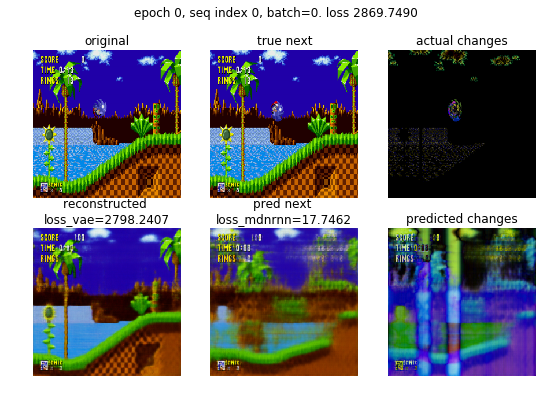

action_pred 2
action_true 2.0
finv loss 0.6980


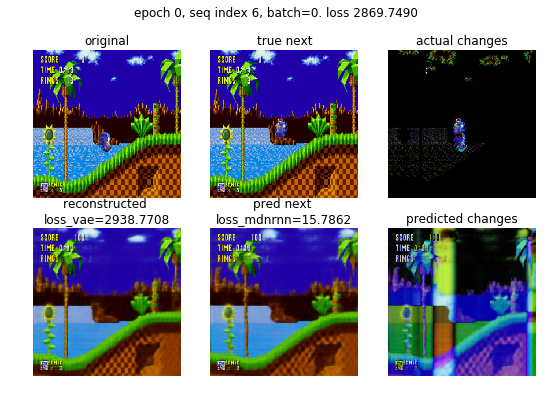

[0/2500] loss=245.1330, loss_rnn=16.2373, loss_inv= 0.7123=1* 0.7123, loss_vae=228.1834=0.0500 * (4563.22 + 0.25*|1.79 - 0|)
[400/2500] loss=176.9530, loss_rnn=15.9270, loss_inv= 0.7174=1* 0.7174, loss_vae=159.9621=0.0500 * (3198.72 + 0.25*|2.09 - 0|)
[800/2500] loss=19.7855, loss_rnn=15.8474, loss_inv= 0.7137=1* 0.7137, loss_vae=143.1737=0.0500 * (2862.90 + 0.25*|2.29 - 0|)
[1200/2500] loss=23.3013, loss_rnn=15.8356, loss_inv= 0.7149=1* 0.7149, loss_vae=141.9188=0.0500 * (2837.82 + 0.25*|2.22 - 0|)
[1600/2500] loss=219.7758, loss_rnn=15.7885, loss_inv= 0.7144=1* 0.7144, loss_vae=136.5219=0.0500 * (2729.88 + 0.25*|2.24 - 0|)
[2000/2500] loss=137.6702, loss_rnn=15.7956, loss_inv= 0.7151=1* 0.7151, loss_vae=136.8310=0.0500 * (2736.05 + 0.25*|2.28 - 0|)
[2400/2500] loss=16.3355, loss_rnn=15.7976, loss_inv= 0.7142=1* 0.7142, loss_vae=136.8314=0.0500 * (2736.05 + 0.25*|2.31 - 0|)
loss=20.7496, loss_rnn=15.7981, loss_inv= 0.7139=1* 0.7139, loss_vae=135.9084=0.0500 * (2717.58 + 0.25*|2.35 - 0

[0/416] loss=196.6976, loss_rnn=16.4076, loss_inv= 0.7266=1* 0.7266, loss_vae=179.5634=0.0500 * (3590.71 + 0.25*|2.24 - 0|)
[400/416] loss=270.7455, loss_rnn=16.1466, loss_inv= 0.7163=1* 0.7163, loss_vae=199.4786=0.0500 * (3989.03 + 0.25*|2.16 - 0|)
loss=281.0150, loss_rnn=16.1594, loss_inv= 0.7164=1* 0.7164, loss_vae=199.9804=0.0500 * (3999.06 + 0.25*|2.17 - 0|)

Epoch 1, loss=15.7981, loss_val=16.1594, loss_vae=2718.1680, loss_vae_val=3999.6069,  loss_finv=nan, loss_finv_vae=nan, ,
tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 9.0
finv loss 0.7123


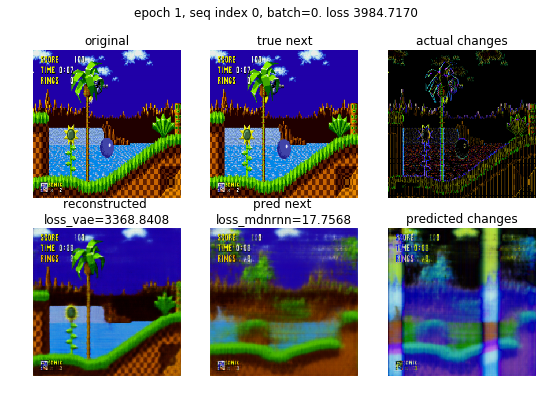

action_pred 2
action_true 7.0
finv loss 0.7123


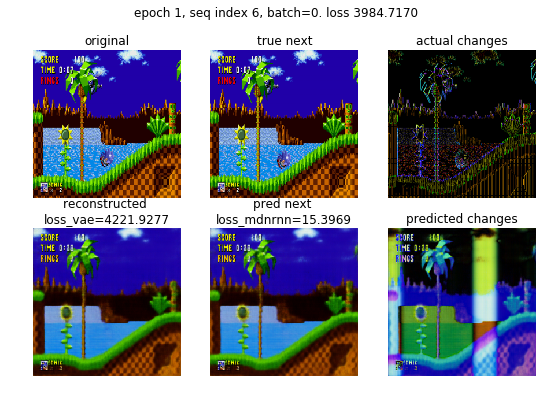

[0/2500] loss=291.5074, loss_rnn=16.5741, loss_inv= 0.7123=1* 0.7123, loss_vae=274.2209=0.0500 * (5484.12 + 0.25*|1.19 - 0|)
[400/2500] loss=268.4326, loss_rnn=15.9076, loss_inv= 0.7137=1* 0.7137, loss_vae=146.8848=0.0500 * (2937.16 + 0.25*|2.14 - 0|)
[800/2500] loss=196.0628, loss_rnn=15.9055, loss_inv= 0.7151=1* 0.7151, loss_vae=143.9462=0.0500 * (2878.38 + 0.25*|2.19 - 0|)
[1200/2500] loss=107.6193, loss_rnn=15.8652, loss_inv= 0.7144=1* 0.7144, loss_vae=142.3951=0.0500 * (2847.35 + 0.25*|2.20 - 0|)
[1600/2500] loss=230.5201, loss_rnn=15.7844, loss_inv= 0.7141=1* 0.7141, loss_vae=133.8946=0.0500 * (2677.30 + 0.25*|2.36 - 0|)
[2000/2500] loss=218.2551, loss_rnn=15.7324, loss_inv= 0.7113=1* 0.7113, loss_vae=130.2659=0.0500 * (2604.71 + 0.25*|2.43 - 0|)
[2400/2500] loss=198.0352, loss_rnn=15.7357, loss_inv= 0.7121=1* 0.7121, loss_vae=130.0851=0.0500 * (2601.10 + 0.25*|2.39 - 0|)
loss=191.3798, loss_rnn=15.7580, loss_inv= 0.7123=1* 0.7123, loss_vae=132.4779=0.0500 * (2648.97 + 0.25*|2.37

[0/416] loss=117.8475, loss_rnn=15.6936, loss_inv= 0.7266=1* 0.7266, loss_vae=101.4274=0.0500 * (2028.02 + 0.25*|2.11 - 0|)
[400/416] loss=227.7433, loss_rnn=16.0253, loss_inv= 0.7160=1* 0.7160, loss_vae=149.5286=0.0500 * (2989.99 + 0.25*|2.32 - 0|)
loss=155.9883, loss_rnn=16.0399, loss_inv= 0.7161=1* 0.7161, loss_vae=151.8211=0.0500 * (3035.85 + 0.25*|2.30 - 0|)

Epoch 2, loss=15.7580, loss_val=16.0399, loss_vae=2649.5583, loss_vae_val=3036.4214,  loss_finv=nan, loss_finv_vae=nan, ,
tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.6980


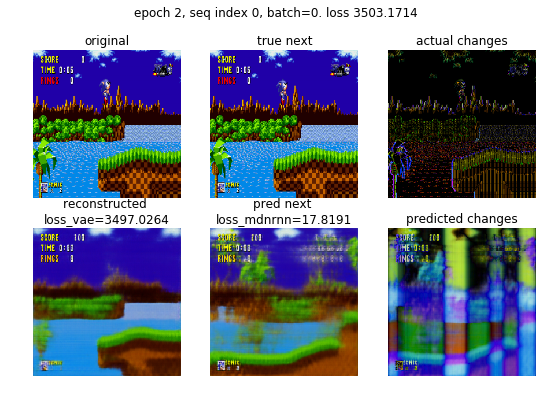

action_pred 2
action_true 2.0
finv loss 0.6980


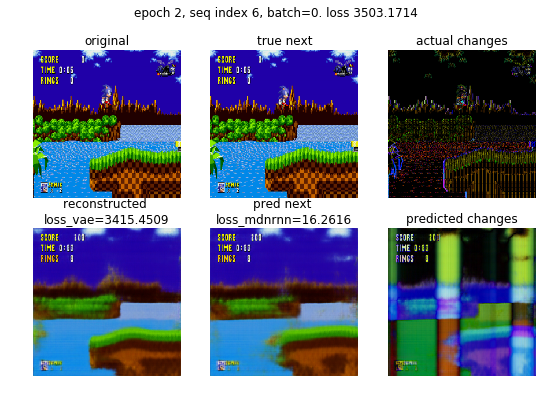

[0/2500] loss=69.8218, loss_rnn=15.2232, loss_inv= 0.6980=1* 0.6980, loss_vae=53.9006=0.0500 * (1077.67 + 0.25*|1.37 - 0|)
[400/2500] loss=16.8975, loss_rnn=15.6095, loss_inv= 0.7170=1* 0.7170, loss_vae=113.3449=0.0500 * (2266.34 + 0.25*|2.22 - 0|)
[800/2500] loss=247.1658, loss_rnn=15.5933, loss_inv= 0.7138=1* 0.7138, loss_vae=108.7513=0.0500 * (2174.38 + 0.25*|2.58 - 0|)
[1200/2500] loss=264.5666, loss_rnn=15.6727, loss_inv= 0.7136=1* 0.7136, loss_vae=121.8131=0.0500 * (2435.65 + 0.25*|2.43 - 0|)
[1600/2500] loss=14.8307, loss_rnn=15.6853, loss_inv= 0.7127=1* 0.7127, loss_vae=121.5357=0.0500 * (2430.11 + 0.25*|2.43 - 0|)
[2000/2500] loss=250.4548, loss_rnn=15.7238, loss_inv= 0.7128=1* 0.7128, loss_vae=125.8834=0.0500 * (2517.06 + 0.25*|2.44 - 0|)
[2400/2500] loss=123.0779, loss_rnn=15.7183, loss_inv= 0.7119=1* 0.7119, loss_vae=125.5880=0.0500 * (2511.15 + 0.25*|2.44 - 0|)
loss=17.9814, loss_rnn=15.7206, loss_inv= 0.7121=1* 0.7121, loss_vae=125.5571=0.0500 * (2510.53 + 0.25*|2.45 - 0|

[0/416] loss=18.9754, loss_rnn=15.6961, loss_inv= 0.6980=1* 0.6980, loss_vae=2.5813=0.0500 * (50.14 + 0.25*|5.96 - 0|)
[400/416] loss=154.8354, loss_rnn=16.0622, loss_inv= 0.7155=1* 0.7155, loss_vae=174.1911=0.0500 * (3483.28 + 0.25*|2.17 - 0|)
loss=129.0003, loss_rnn=16.0612, loss_inv= 0.7155=1* 0.7155, loss_vae=172.9834=0.0500 * (3459.13 + 0.25*|2.16 - 0|)

Epoch 3, loss=15.7206, loss_val=16.0612, loss_vae=2511.1416, loss_vae_val=3459.6682,  loss_finv=nan, loss_finv_vae=nan, ,
tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 8.0
finv loss 0.7123


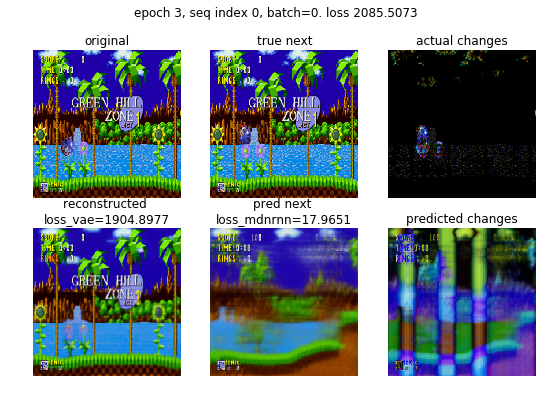

action_pred 2
action_true 7.0
finv loss 0.7123


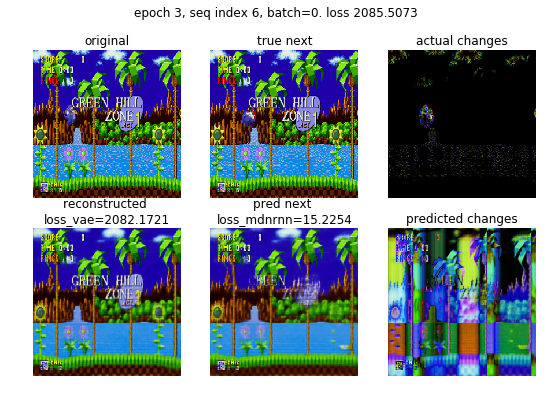

[0/2500] loss=238.9958, loss_rnn=16.1133, loss_inv= 0.7266=1* 0.7266, loss_vae=222.1559=0.0500 * (4442.89 + 0.25*|0.92 - 0|)
[400/2500] loss=138.7883, loss_rnn=15.9255, loss_inv= 0.7133=1* 0.7133, loss_vae=157.0976=0.0500 * (3141.49 + 0.25*|1.87 - 0|)
[800/2500] loss=104.2873, loss_rnn=15.7845, loss_inv= 0.7130=1* 0.7130, loss_vae=143.8888=0.0500 * (2877.27 + 0.25*|2.03 - 0|)
[1200/2500] loss=146.5478, loss_rnn=15.7497, loss_inv= 0.7132=1* 0.7132, loss_vae=134.8058=0.0500 * (2695.54 + 0.25*|2.30 - 0|)
[1600/2500] loss=123.6543, loss_rnn=15.7397, loss_inv= 0.7138=1* 0.7138, loss_vae=134.3501=0.0500 * (2686.43 + 0.25*|2.29 - 0|)
[2000/2500] loss=199.8557, loss_rnn=15.7328, loss_inv= 0.7136=1* 0.7136, loss_vae=131.9835=0.0500 * (2639.09 + 0.25*|2.30 - 0|)
[2400/2500] loss=294.8479, loss_rnn=15.7351, loss_inv= 0.7126=1* 0.7126, loss_vae=130.0755=0.0500 * (2600.92 + 0.25*|2.36 - 0|)
loss=172.9854, loss_rnn=15.7425, loss_inv= 0.7127=1* 0.7127, loss_vae=130.5234=0.0500 * (2609.88 + 0.25*|2.36

[0/416] loss=292.0697, loss_rnn=17.1983, loss_inv= 0.6980=1* 0.6980, loss_vae=274.1734=0.0500 * (5483.00 + 0.25*|1.89 - 0|)
[400/416] loss=129.2720, loss_rnn=15.9828, loss_inv= 0.7162=1* 0.7162, loss_vae=136.4931=0.0500 * (2729.22 + 0.25*|2.57 - 0|)
loss=126.2233, loss_rnn=15.9718, loss_inv= 0.7161=1* 0.7161, loss_vae=135.6578=0.0500 * (2712.52 + 0.25*|2.56 - 0|)

Epoch 4, loss=15.7425, loss_val=15.9718, loss_vae=2610.4688, loss_vae_val=2713.1558,  loss_finv=nan, loss_finv_vae=nan, ,
tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 0.0
finv loss 0.7123


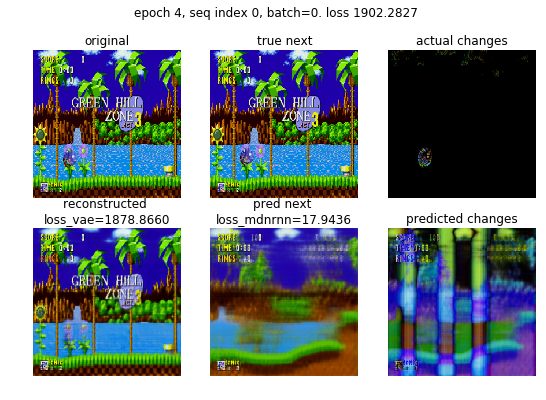

action_pred 2
action_true 8.0
finv loss 0.7123


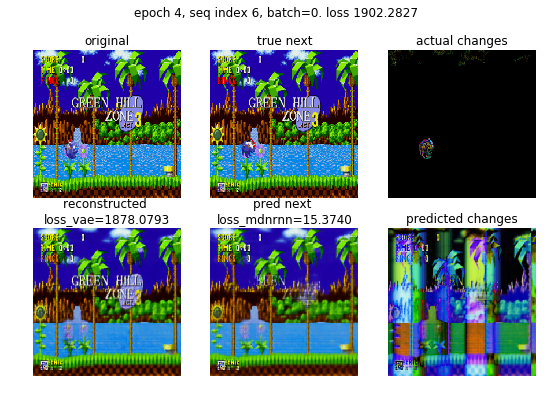

[0/2500] loss=15.9194, loss_rnn=15.1920, loss_inv= 0.6552=1* 0.6552, loss_vae=0.0722=0.0500 * (0.37 + 0.25*|4.30 - 0|)
[400/2500] loss=232.0685, loss_rnn=15.5615, loss_inv= 0.7106=1* 0.7106, loss_vae=108.5475=0.0500 * (2170.34 + 0.25*|2.46 - 0|)
[800/2500] loss=167.2601, loss_rnn=15.6737, loss_inv= 0.7106=1* 0.7106, loss_vae=116.5034=0.0500 * (2329.42 + 0.25*|2.59 - 0|)
[1200/2500] loss=243.4352, loss_rnn=15.6962, loss_inv= 0.7103=1* 0.7103, loss_vae=120.6957=0.0500 * (2413.27 + 0.25*|2.57 - 0|)
[1600/2500] loss=310.1076, loss_rnn=15.7460, loss_inv= 0.7110=1* 0.7110, loss_vae=124.9600=0.0500 * (2498.57 + 0.25*|2.52 - 0|)
[2000/2500] loss=178.3238, loss_rnn=15.7508, loss_inv= 0.7120=1* 0.7120, loss_vae=128.0450=0.0500 * (2560.28 + 0.25*|2.49 - 0|)
[2400/2500] loss=222.6283, loss_rnn=15.7273, loss_inv= 0.7123=1* 0.7123, loss_vae=127.3224=0.0500 * (2545.83 + 0.25*|2.45 - 0|)
loss=112.4964, loss_rnn=15.7252, loss_inv= 0.7125=1* 0.7125, loss_vae=127.2338=0.0500 * (2544.06 + 0.25*|2.45 - 0|)

[0/416] loss=222.7205, loss_rnn=16.4961, loss_inv= 0.7266=1* 0.7266, loss_vae=205.4978=0.0500 * (4109.57 + 0.25*|1.53 - 0|)
[400/416] loss=196.2812, loss_rnn=16.1066, loss_inv= 0.7165=1* 0.7165, loss_vae=153.4767=0.0500 * (3068.96 + 0.25*|2.30 - 0|)
loss=184.2259, loss_rnn=16.0931, loss_inv= 0.7165=1* 0.7165, loss_vae=153.3125=0.0500 * (3065.68 + 0.25*|2.29 - 0|)

Epoch 5, loss=15.7252, loss_val=16.0931, loss_vae=2544.6753, loss_vae_val=3066.2490,  loss_finv=nan, loss_finv_vae=nan, ,
tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.7123


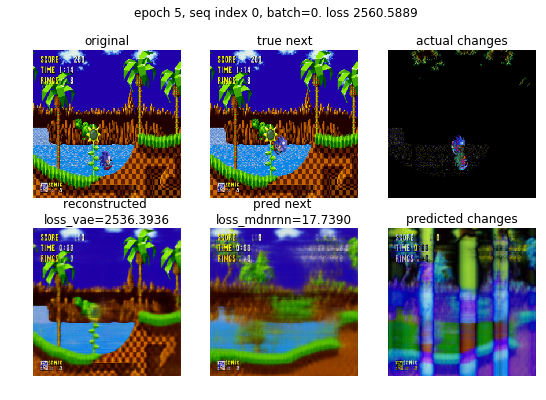

action_pred 2
action_true 2.0
finv loss 0.7123


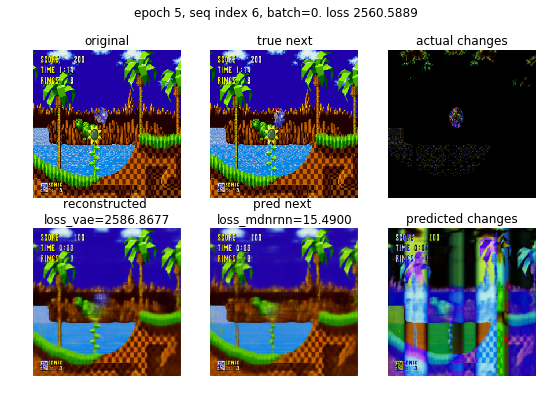

[0/2500] loss=350.9697, loss_rnn=16.7394, loss_inv= 0.7266=1* 0.7266, loss_vae=333.5037=0.0500 * (6669.87 + 0.25*|0.82 - 0|)



KeyboardInterrupt: 

In [15]:
for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}, loss_vae={:2.4f}, loss_vae_val={:2.4f},  loss_finv={:2.4f}, loss_finv_vae={:2.4f}, ,'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae']),
        np.mean(info['loss_finv']),
        np.mean(info_val['loss_finv'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_mdnrnn_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
    torch.save(vae.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_vae_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
    torch.save(finv.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_finv_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
      
    # Tidy
    torch.cuda.empty_cache()

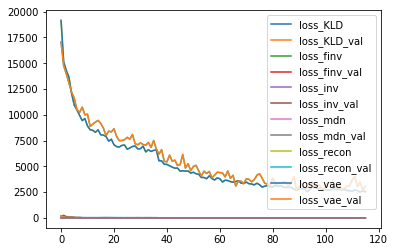

In [16]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()
df_history.to_csv(history_file, index=False)

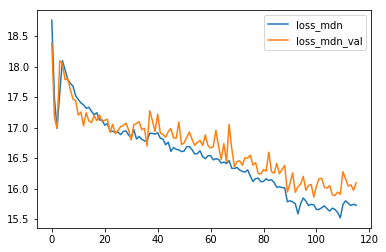

In [17]:
df_history[['loss_mdn','loss_mdn_val']].plot()

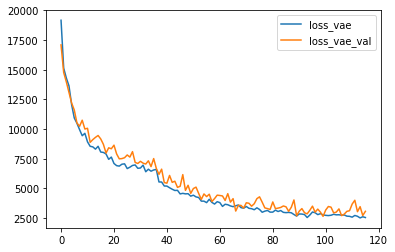

In [18]:
df_history[['loss_vae','loss_vae_val']].plot()

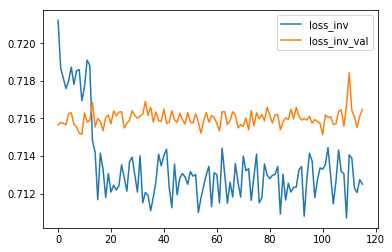

In [19]:
df_history[['loss_inv','loss_inv_val']].plot()

## Save

In [20]:
torch.save(mdnrnn.state_dict(), save_file_rnn)
torch.save(vae.state_dict(), save_file_vae)
torch.save(finv.state_dict(), save_file_finv)

## View

tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.6980


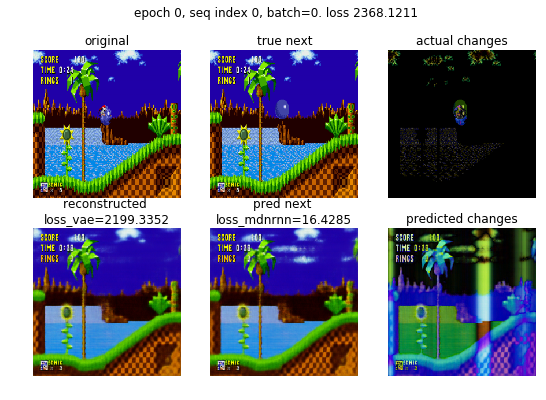

action_pred 2
action_true 8.0
finv loss 0.6980


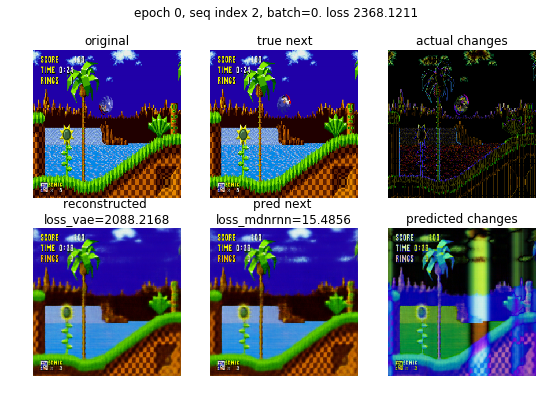

action_pred 2
action_true 8.0
finv loss 0.6980


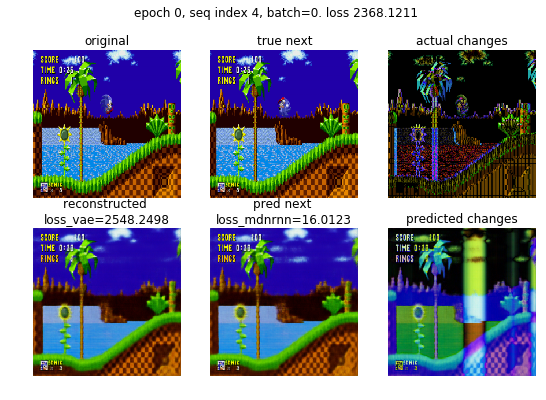

action_pred 2
action_true 2.0
finv loss 0.6980


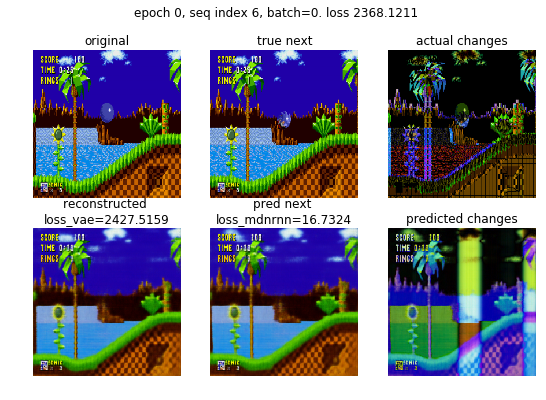

In [21]:
plot_results(loader_test, n=4, epoch=0)

tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.7123


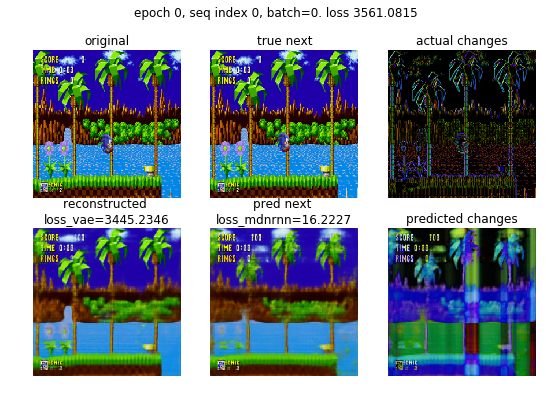

action_pred 2
action_true 5.0
finv loss 0.7123


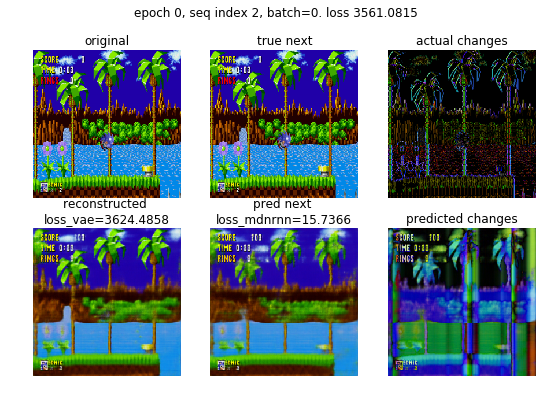

action_pred 2
action_true 1.0
finv loss 0.7123


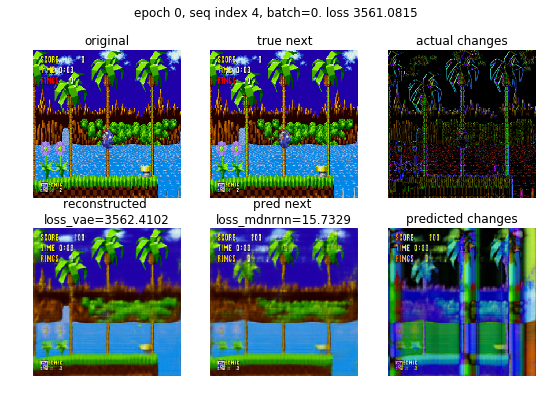

action_pred 2
action_true 2.0
finv loss 0.7123


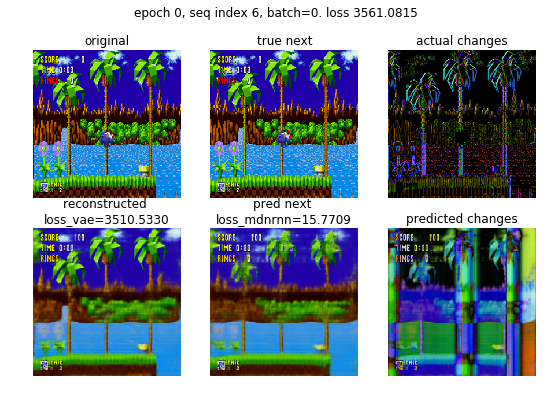

In [22]:
plot_results(loader_train, n=4, epoch=0)

In [23]:
torch.cuda.empty_cache()

# Summarize models

In [24]:
from IPython.display import display
with torch.no_grad():
    img = np.random.randn(image_size, image_size, 3)
    action = np.array(np.random.randint(0,action_dim))[np.newaxis]
    action = Variable(torch.from_numpy(action)).float().cuda()[np.newaxis]
    gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
    if cuda:
        gpu_img = gpu_img.cuda()
    with TorchSummarizeDf(vae) as tdf:
        x, mu_vae, logvar_vae = vae.forward(gpu_img)
        z = vae.sample(mu_vae, logvar_vae)
        df_vae = tdf.make_df()

    display(df_vae[df_vae.level<2])
    
    with TorchSummarizeDf(mdnrnn) as tdf: 
        pi, mu, sigma, hidden_state = mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.repeat((1,2)))
        z_next = mdnrnn.sample(pi, mu, sigma)
        df_mdnrnn = tdf.make_df()
    
    display(df_mdnrnn)
    

    with TorchSummarizeDf(finv) as tdf:
        finv(z.repeat((1,2,1)), z_next)   
        df_finv = tdf.make_df()
    display(df_finv)

#     with TorchSummarizeDf(world_model) as tdf:
#         world_model(gpu_img, action)
#         df_world_model = tdf.make_df()
#     display(df_world_model[df_world_model.level<2])
    
    del img, action, gpu_img, x, mu, z, z_next, mu_vae, logvar_vae, pi, sigma

Total parameters 8909862
Total trainable parameters 8909862


name    class_name           input_shape          output_shape  \
4    encoder.0   BasicConv2d   [(-1, 3, 256, 256)]  [(-1, 48, 256, 256)]   
42   encoder.1    ConvBlock5  [(-1, 48, 256, 256)]  [(-1, 96, 128, 128)]   
80   encoder.2    ConvBlock5  [(-1, 96, 128, 128)]   [(-1, 144, 64, 64)]   
118  encoder.3    ConvBlock5   [(-1, 144, 64, 64)]   [(-1, 192, 32, 32)]   
156  encoder.4    ConvBlock5   [(-1, 192, 32, 32)]   [(-1, 240, 16, 16)]   
194  encoder.5    ConvBlock5   [(-1, 240, 16, 16)]     [(-1, 288, 8, 8)]   
232  encoder.6    ConvBlock5     [(-1, 288, 8, 8)]      [(-1, 32, 8, 8)]   
233         mu        Linear          [(-1, 2048)]           [(-1, 256)]   
234     logvar        Linear          [(-1, 2048)]           [(-1, 256)]   
235          z        Linear           [(-1, 256)]          [(-1, 2048)]   
273  decoder.0  DeconvBlock5      [(-1, 32, 8, 8)]     [(-1, 288, 8, 8)]   
311  decoder.1  DeconvBlock5     [(-1, 288, 8, 8)]   [(-1, 240, 16, 16)]   
349  decoder.2  DeconvBlock5   [(-1, 240, 16, 16)]   [(-1, 192, 32, 32)]   
387  decoder.3  DeconvBlock5   [(-1, 192, 32, 32)]   [(-1, 144, 64, 64)]   
425  decoder.4  DeconvBlock5   [(-1, 144, 64, 64)]  [(-1, 96, 128, 128)]   
463  decoder.5  DeconvBlock5  [(-1, 96, 128, 128)]  [(-1, 48, 256, 256)]   
464  decoder.6        Conv2d  [(-1, 48, 256, 256)]   [(-1, 3, 256, 256)]   
465    sigmoid       Sigmoid   [(-1, 3, 256, 256)]   [(-1, 3, 256, 256)]   

     nb_params  level  
4         1440      1  
42       93213      1  
80      281034      1  
118     566055      1  
156     948276      1  
194    1427697      1  
232     351550      1  
233     524544      0  
234     524544      0  
235     526336      0  
273      98254      1  
311    1506078      1  
349    1012401      1  
387     615924      1  
425     316647      1  
463     114570      1  
464       1299      1  
465          0      0

Total parameters 1778688
Total trainable parameters 1778688


name class_name                                        input_shape  \
1  rnn       LSTM  [[(-1, 2, 266)], [[(-1, 1, 128)], [(-1, 1, 128...   
2  ln1     Linear                             [(-1, 128), (-1, 128)]   
3  ln2     Linear                             [(-1, 128), (-1, 128)]   
4  mdn     Linear                             [(-1, 640), (-1, 640)]   

                                        output_shape  nb_params  level  
1  [[(-1, 2, 128)], [[(-1, 1, 128)], [(-1, 1, 128...     202752      0  
2                             [(-1, 128), (-1, 128)]      16512      0  
3                             [(-1, 640), (-1, 640)]      82560      0  
4                           [(-1, 2304), (-1, 2304)]    1476864      0

Total parameters 199690
Total trainable parameters 199690


name class_name     input_shape    output_shape  nb_params  level
1  ln1     Linear  [(-1, 2, 512)]  [(-1, 2, 256)]     131328      0
2  ln2     Linear  [(-1, 2, 256)]  [(-1, 2, 256)]      65792      0
3  ln3     Linear  [(-1, 2, 256)]   [(-1, 2, 10)]       2570      0

# DEBUG